# ✈️✈️✈️ End-to-end Multi-class Military Aircraft Detection Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2 Object Detection API to train an SSD-MobileNet model or EfficientDet model with a custom dataset and convert it to TensorFlow Lite format.

Proceedure Roadmap:
When multiple annotated subjects in a single image, I am dealing with a multi-object detection problem. Here's a general approach to prepare the dataset for train split testing:

* Annotation: Each individual object in an image should be labeled separately. You'll want to create "bounding boxes" around each object in an image, and then label that box with the type of aircraft it contains. Tools like Labelbox, LabelImg, or VGG Image Annotator (VIA) can help with this process.

* Format the Data: Your labels should include not only the type of aircraft, but also the location of the bounding box within the image. These labels are usually saved in a structured format such as XML or JSON. For example, in TensorFlow's Object Detection API, they use the TFRecord format.

* Model Selection: You'll want to choose a model architecture that's designed for object detection. Some examples include Single Shot MultiBox Detector (SSD), Region-CNN (R-CNN), and You Only Look Once (YOLO).

* Training: When you train your model, it will learn to not only classify different types of aircraft but also to predict the bounding boxes around them in the image.

* Evaluation: Finally, you'll want to choose an appropriate evaluation metric. For multi-object detection tasks, mean Average Precision (mAP) is often used.

## 1. Problem

Identifying the type of airplain given an image of a aircraft.

When I take a photo of an airplane, I want to know what types of airplain and the number of airplane is in the photo.

## 2. Data

The data we're using is from Kaggle's "Military Aircraft Detection Dataset"

https://www.kaggle.com/datasets/a2015003713/militaryaircraftdetectiondataset

* After downloading the file onto local HD, I seperate the labeled csv file by concatenate all the labeled datasets into one `combined.csv` dataset.
* Start upload all the images + `combined.csv` onto Google Drive
* Applied the bounding boxes from the `combined.csv` onto the image sample dataset

## 3. Evaluation

The evaluation is a file with prediction probobilities for each aircraft of each test image.

## 4. Dataset Features

* The dataset contain images with multiple and corrispnding labeling .csv files with the same file names.
* Each fragmented labeling csv file has precised x & y axis of value that can be used as the 4 corners bounding boxes for designated training areas for machines to learn.
* We are annotating the image samples with the provided xy axieses on each of the corrisponding labels (csv).
* There are 43 types of aircrafts (classes) for machine to learn.
* There are 10k+ samples total for further train-split-test modeling.

## 2. Install TensorFlow Object Detection Dependencies

First, we'll install the TensorFlow Object Detection API in this Google Colab instance. This requires cloning the [TensorFlow models repository](https://github.com/tensorflow/models) and running a couple installation commands. Click the play button to run the following sections of code.


In [1]:
# Import packages
import os
import cv2
import numpy as np
import sys
import glob
import random
import importlib.util
from tensorflow.lite.python.interpreter import Interpreter
from tensorflow.keras.optimizers import SGD
import pandas as pd
from google.colab.patches import cv2_imshow
from google.colab import drive


import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Clone the tensorflow models repository from GitHub
!git clone --depth 1 https://github.com/tensorflow/models

# Upgrade the tensorflow to the newest version
!pip install --upgrade tensorflow

Cloning into 'models'...
remote: Enumerating objects: 3916, done.
remote: Counting objects: 100% (3916/3916), done.
remote: Compressing objects: 100% (3025/3025), done.
remote: Total 3916 (delta 1129), reused 1821 (delta 838), pack-reused 0
Receiving objects: 100% (3916/3916), 49.65 MiB | 30.23 MiB/s, done.
Resolving deltas: 100% (1129/1129), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 71.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 42.9 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.6.3
    Uninstalling typing_extensions-4.6.3:
      Successfully uninstalled typing_extensions-4.6.3
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow

In [3]:
# Copy setup files into models/research folder
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
#cp object_detection/packages/tf2/setup.py .

In [4]:
import sys
print(sys.version)


3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]


In [5]:
# Modify setup.py file to install the tf-models-official repository targeted at TF v2.8.0
import re
with open('/content/models/research/object_detection/packages/tf2/setup.py') as f:
    s = f.read()

with open('/content/models/research/setup.py', 'w') as f:
    # Set fine_tune_checkpoint path
    s = re.sub('tf-models-official>=2.5.1',
               'tf-models-official==2.8.0', s)
    f.write(s)

In [6]:
# Install the Object Detection API
!pip install /content/models/research/

# Need to downgrade to TF v2.8.0 due to Colab compatibility bug with TF v2.10 (as of 10/03/22)
# !pip install tensorflow==2.8.0

!pip install tensorflow==2.12

Processing ./models/research
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 68.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 20.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 50.3 MB/s et

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 83.7 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
    Uninstalling tensorboard-data-server-0.6.1:
      Successfully uninstalled tensorboard-data-server-0.6.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling

Let's test our installation by running `model_builder_tf2_test.py` to make sure everything is working as expected. Run the following code block and confirm that it finishes without errors. If you get errors, try Googling them or checking the FAQ at the end of this Colab.

In [7]:
# Run Model Bulider Test file, just to verify everything's working properly
!python /content/models/research/object_detection/builders/model_builder_tf2_test.py

2023-07-08 03:34:11.441443: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Running tests under Python 3.10.12: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2023-07-08 03:34:21.752517: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
W0708 03:34:21.854727 139684163319616 batch_normalization.py:1426] `tf.keras.layers.experimental.SyncBatchNormalization` endpoint is deprecated and will be removed in a future release. Please use `tf.keras.layers.BatchNormalization` with parameter `synchronized` set to True.
W0708 03:34:21.887367 139684163319616 batch_normalization.py:1426] `tf.keras.layers.experimental.SyncBatchNormalization` endpoint is deprecated and will be removed in a future release. Please use `tf.keras.layers.BatchNormalization` with parameter `synchronized` set 

### Image and Labeling Data prep work
I want to test out the labeling data with the corresponding file name and place bounding boxes as preview to check for the authenticity. The following info is added to the image dataset:

* bounding boxes
* `class` labeling value added to the bounding boxes

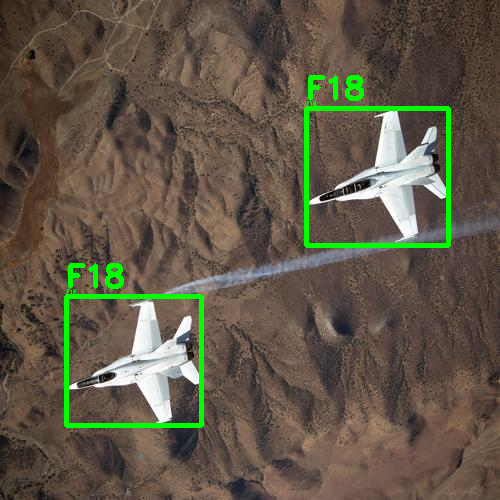

In [8]:
import cv2
import pandas as pd
from google.colab.patches import cv2_imshow
from google.colab import drive

# Read the CSV file
df_testing = pd.read_csv('drive/MyDrive/images/val/ffa565e4f573979207ea525e63c204d5.csv')

# Filter the rows related to the image
df_img = df_testing[df_testing['filename'] == 'ffa565e4f573979207ea525e63c204d5']

# Read the image once
image_path = 'drive/MyDrive/images/val/ffa565e4f573979207ea525e63c204d5.jpg'
image = cv2.imread(image_path)

# Check if the image is correctly loaded
if image is None:
    print(f"No image found at {image_path}")
else:
    # Loop through each row in the filtered dataframe
    for index, row in df_img.iterrows():
        # Get the bounding box coordinates
        xmin = int(row['xmin'])
        ymin = int(row['ymin'])
        xmax = int(row['xmax'])
        ymax = int(row['ymax'])

        # Get the class label
        label = str(row['class'])

        # Draw the bounding box and the label on the image
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)
        cv2.putText(image, label, (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)

    # Display the image with all bounding boxes
    cv2_imshow(image)

### Labeling DataSet Prep work

I need to concatenate all the labeling CSV files from scattered pieces into one unified labeling dataset as "Combined.csv".

In [9]:
import os

# specify the directory you're starting from
rootDir = 'drive/MyDrive/Military Aircraft Recognition'

# create an empty list to store all dataframes
all_dfs = []

# iterate through all files in the directory
for dirName, subdirList, fileList in os.walk(rootDir):
    for fname in fileList:
        # check if the file is a csv file
        if fname.endswith('.csv'):
            # create a dataframe from the csv file and append it to the list
            df = pd.read_csv(os.path.join(dirName, fname))
            all_dfs.append(df)

# concatenate all dataframes in the list
combined_df = pd.concat(all_dfs, ignore_index=True)

# save the combined dataframe to a csv file
combined_df.to_csv(os.path.join(rootDir, 'combined.csv'), index=False)

combined_df.head

ValueError: ignored

In [ ]:
# Drop all scattered labeling datasets leaving only the combined labeling dataset
directory = 'drive/MyDrive/Military Aircraft Recognition'

for filename in os.listdir(directory):
    if filename.endswith(".csv") and filename != "combined.csv":
        os.remove(os.path.join(directory, filename))

In [ ]:
import os

# directory path
directory = 'drive/MyDrive/Military Aircraft Recognition'

# iterate over all the csv files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # strip off the .csv from the filename
        base_name = os.path.splitext(filename)[0]

        # check if corresponding jpg file exists
        if not os.path.exists(os.path.join(directory, base_name + '.jpg')):
            # if not, delete the csv file
            os.remove(os.path.join(directory, filename))

print("Task completed. All CSV files without corresponding JPG files have been removed.")


#### For the dataset prepping purposes, I had to modify the labeling dataset by putting back the scattered csv labeling to make sure the Train-Split-Test machine leaning model works

In [ ]:
import os

# directory path
directory = 'drive/MyDrive/Military Aircraft Recognition'

# initialize counters
num_csv_files = 0
num_jpg_files = 0

# iterate over all files in the directory
for filename in os.listdir(directory):
    # increment counters based on file extension
    if filename.endswith('.csv'):
        num_csv_files += 1
    elif filename.endswith('.jpg'):
        num_jpg_files += 1

print(f"Number of CSV files: {num_csv_files}")
print(f"Number of JPG files: {num_jpg_files}")


In [ ]:
import os

directory = 'drive/MyDrive/Military Aircraft Recognition'

# initialize sets for filenames without extension
csv_files = set()
jpg_files = set()

# iterate over all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        csv_files.add(filename[:-4])  # remove file extension
    elif filename.endswith('.jpg'):
        jpg_files.add(filename[:-4])  # remove file extension

# find jpg files without a corresponding csv file
jpg_without_csv = jpg_files - csv_files

print(f"JPG files without a corresponding CSV: {jpg_without_csv}")


In [ ]:
# directory path
directory = 'drive/MyDrive/Military Aircraft Recognition'

# initialize counters
num_csv_files = 0
num_jpg_files = 0

# iterate over all files in the directory
for filename in os.listdir(directory):
    # increment counters based on file extension
    if filename.endswith('.csv'):
        num_csv_files += 1
    elif filename.endswith('.jpg'):
        num_jpg_files += 1

print(f"Number of CSV files: {num_csv_files}")
print(f"Number of JPG files: {num_jpg_files}")

### Apply the `Combined.csv` dataset for the image annotation labeling to all images samples

I want to use the combined.csv labeling dataset as the annotation bounding box under the "xmin, xmax, ymin, ymax" columns, and column "class" for labeling next to the bounding boxes for all the images dataset inside the same directory. Here is the following code so far:

In [ ]:
# Read the CSV file
df_testing = pd.read_csv('drive/MyDrive/Military Aircraft Recognition/combined.csv')

df_testing.tail()

Check for the plotlib graphs for the qty per each classes

In [ ]:
# How many images are there of each class?
df_testing["class"].value_counts().plot.bar(figsize=(20, 10))

In [ ]:
# let's view an image
from IPython.display import Image
Image('drive/MyDrive/Military Aircraft Recognition/82265f597e80518a4554b0938783d2df.jpg')

### At this point, the image sample dataset flooded my Google Drive

The dataset is simply TOO big for the cloud drive to hold all the image sample dataset

In [ ]:
# Set the directory you want to start from
rootDir = 'drive/MyDrive/Military Aircraft Recognition/'

# Set the file size limit (in bytes)
size_limit = 3 * 1024 * 1024  # 3 MB

# Walk through all files and subdirectories in the directory
for dirpath, dirs, files in os.walk(rootDir):
    for filename in files:
        file_path = os.path.join(dirpath, filename)
        # Get file size
        file_size = os.path.getsize(file_path)
        # If file size is greater than limit, delete the file
        if file_size > size_limit:
            os.remove(file_path)
            print(f'{file_path} removed')

Make sure the number of the image samples is correct in the directory

In [ ]:
# Specify the directory
dir_path = 'drive/MyDrive/Military Aircraft Recognition'

# Get a list of all files and directories in the specified directory
files = os.listdir(dir_path)

# Use a list comprehension to filter out directories, leaving only files
files = [f for f in files if os.path.isfile(os.path.join(dir_path, f))]

# Print the number of files
print(len(files))

#### need to count the amount of duplicated files by filename in a directory

In [ ]:
import os
from collections import Counter

# Set the directory you want to start from
rootDir = 'drive/MyDrive/Military Aircraft Recognition/'

# Get list of all files
file_list = []
for dirName, subdirList, fileList in os.walk(rootDir):
    for fname in fileList:
        file_list.append(fname)

# Count the frequency of each file
counter = Counter(file_list)

# Find duplicates
duplicates = {file: count for file, count in counter.items() if count > 1}

if len(duplicates) > 0:
    print(f"Found {len(duplicates)} duplicate files.")
else:
    print("No duplicate files found.")

Lets see how many images sample files that is missing from the directory

In [ ]:
# Get all the filenames from the directory (without extensions)
dir_filenames = [os.path.splitext(f)[0] for f in os.listdir('drive/MyDrive/Military Aircraft Recognition/') if f.endswith('.jpg') or f.endswith('.jpeg')]

# Get all the filenames from the CSV
csv_filenames = df['filename'].unique()

# Find the filenames in the CSV that are not in the directory
missing_files = [f for f in csv_filenames if f not in dir_filenames]

# Print or return the missing filenames
print(len(missing_files))

Also show the sizes of the directory

In [ ]:
def get_dir_size(path='.'):
    total = 0
    with os.scandir(path) as it:
        for entry in it:
            if entry.is_file():
                total += entry.stat().st_size
            elif entry.is_dir():
                total += get_dir_size(entry.path)
    return total

# Replace 'your_directory_path' with the actual path
directory_path = 'drive/MyDrive/Military Aircraft Recognition/'
total_size = get_dir_size(directory_path)

print(f'Total size of directory "{directory_path}" is {total_size / (1024 * 1024):.2f} MB')

#### Clean the labeling dataset to match with the total amount of the sample image dataset in the directory

and resave it to a new labeling dataset

In [ ]:
# Set the directory you want to start from
rootDir = 'drive/MyDrive/Military Aircraft Recognition/'

# Collect all filenames
filenames = [os.path.splitext(f)[0] for f in os.listdir(rootDir) if f.endswith('.jpg')]

# Read the combined CSV file
df = pd.read_csv(os.path.join(rootDir, 'combined.csv'))

# Filter the dataframe to keep only rows where 'filename' is in the list of image filenames
df = df[df['filename'].isin(filenames)]

# Save the filtered dataframe back to the combined CSV file
df.to_csv(os.path.join(rootDir, 'combined.csv'), index=False)

Double check the total rows of sample for the "updated_combined.csv" labeling dataset

In [ ]:
print(len(df))

In [ ]:
# Filter rows where 'filename' column contains the string '0a2a11a8658d69b6cd1fd23c5f4513bd'
df_filtered = df_testing[df_testing['filename'] == '0a2a11a8658d69b6cd1fd23c5f4513bd']

# Display the filtered DataFrame
print(df_filtered)

### Try to access the combined dataset labels with rows corresponding to the image sample

lets try to show the first 5 sample rows according to the label dataset

In [ ]:
# Assuming you have a dataframe df_combined
unique_filenames = df['filename'].unique()

# Process only the first 5 unique images
for filename in unique_filenames[:10]:
    df_img = df_testing[df_testing['filename'] == filename]

    # Read the image once
    image_path = f'drive/MyDrive/images/{filename}.jpg'
    image = cv2.imread(image_path)

    # Check if the image is correctly loaded
    if image is None:
        print(f"No image found at {image_path}")
        continue

    # Loop through each row in the filtered dataframe
    for index, row in df_img.iterrows():
        # Get the bounding box coordinates
        xmin = int(row['xmin'])
        ymin = int(row['ymin'])
        xmax = int(row['xmax'])
        ymax = int(row['ymax'])

        # Get the class label
        label = str(row['class'])

        # Draw the bounding box and the label on the image
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)
        cv2.putText(image, label, (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)

    # Display the image with all bounding boxes
    cv2_imshow(image)

In [ ]:
# Assuming you have a dataframe df_combined
unique_filenames = df_testing['filename'].unique()

# Process only the first 5 unique images
for filename in unique_filenames[:10]:
    df_img = df_testing[df_testing['filename'] == filename]

    # Read the image once
    image_path = f'drive/MyDrive/Military Aircraft Recognition/{filename}.jpg'
    image = cv2.imread(image_path)

    # Check if the image is correctly loaded
    if image is None:
        print(f"No image found at {image_path}")
        continue

    # Loop through each row in the filtered dataframe
    for index, row in df_img.iterrows():
        # Get the bounding box coordinates
        xmin = int(row['xmin'])
        ymin = int(row['ymin'])
        xmax = int(row['xmax'])
        ymax = int(row['ymax'])

        # Get the class label
        label = str(row['class'])

        # Draw the bounding box and the label on the image
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)
        cv2.putText(image, label, (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)

    # Display the image with all bounding boxes
    cv2_imshow(image)

## Saving the image samples with bounding boxes labeled from combined.csv

Due to the Google Drive space constrain, I have to write over the exisiting image files with the new versions of image plus bounding boxes without making duplication of all the dataset

Before we committ the time into the `imwrite` pasting over the exisiting

In [ ]:
import time

rootDir = 'drive/MyDrive/Military Aircraft Recognition/'

# Read the combined CSV file
df = pd.read_csv(os.path.join(rootDir, 'combined.csv'))

# Determine the number of rows in your CSV
total_rows = len(df)

# Determine the number of images you want to process for the time estimation
num_images_for_test = 5000

start_time = time.time()

# Perform your operation on a subset of your data
for _, row in df.head(num_images_for_test).iterrows():
    image_filename = row['filename']
    image = cv2.imread(os.path.join(rootDir, image_filename + '.jpg'))

    # If image file not found, continue with next iteration
    if image is None:
        continue

    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']

    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)

end_time = time.time()

# Calculate elapsed time for the test
elapsed_time_test = end_time - start_time

# Extrapolate this to your full dataset
estimated_time_full_dataset = (elapsed_time_test / num_images_for_test) * total_rows

print(f"Estimated time for full dataset: {estimated_time_full_dataset} seconds")


Seems like the progress of bounding box label is not complete. I need to check how many are not being labeled so far.

In [ ]:
import cv2
import numpy as np

# Set the bounding box color
bbox_color = [0, 255, 0]  # RGB for green

# Initialize a counter for images without bounding boxes
counter_no_bbox = 0

# Go through all unique image filenames
for filename in unique_filenames:
    image_path = f'drive/MyDrive/Military Aircraft Recognition/{filename}.jpg'
    image = cv2.imread(image_path)

    # Check if the image is correctly loaded
    if image is None:
        print(f"No image found at {image_path}")
        continue

    # Create a mask for pixels that match the bounding box color
    mask = np.all(image == bbox_color, axis=-1)

    # Now 'mask' is a 2D array where True indicates a bounding box pixel
    # Count the number of True values to see how many bounding box pixels there are
    bbox_pixel_count = np.count_nonzero(mask)

    # If bbox_pixel_count is zero, the image does not have a bounding box
    if bbox_pixel_count == 0:
        counter_no_bbox += 1

print(f"Number of images without bounding boxes: {counter_no_bbox}")


Still have some images not labeled. by bounding boxes, i will delete them and keep the rest of the image with bounding boxes inside dataset

In [ ]:
import os
import cv2
import numpy as np

# Set the bounding box color
bbox_color = [0, 255, 0]  # RGB for green

# Directory containing your images
image_directory = 'drive/MyDrive/Military Aircraft Recognition'

# Iterate over all files in the image directory
for filename in os.listdir(image_directory):
    # Check if the file is an image (has .jpg extension)
    if filename.endswith('.jpg'):
        image_path = os.path.join(image_directory, filename)
        image = cv2.imread(image_path)

        # Check if the image is correctly loaded
        if image is None:
            print(f"No image found at {image_path}")
            continue

        # Create a mask for pixels that match the bounding box color
        mask = np.all(image == bbox_color, axis=-1)

        # Now 'mask' is a 2D array where True indicates a bounding box pixel
        # Count the number of True values to see how many bounding box pixels there are
        bbox_pixel_count = np.count_nonzero(mask)

        # If bbox_pixel_count is zero, the image does not have a bounding box and needs to be deleted
        if bbox_pixel_count == 0:
            os.remove(image_path)
            print(f"Deleted {image_path}")

print("Finished deleting all images without bounding boxes.")


Check again and see if the remaining images with bounding boxes matches the total 10683 images minus the deleted images without bounding boxes

In [ ]:
# Specify the directory
dir_path = 'drive/MyDrive/Military Aircraft Recognition'

# Get a list of all files and directories in the specified directory
files = os.listdir(dir_path)

# Use a list comprehension to filter out directories, leaving only files
files = [f for f in files if os.path.isfile(os.path.join(dir_path, f))]

# Print the number of files
print(len(files))

Cleaning the labeling datasets again by deleting the extra sample rows that did not get labeled by the bounding boxes

In [ ]:
# Set the directory you want to start from
rootDir = 'drive/MyDrive/Military Aircraft Recognition/'

# Collect all filenames
filenames = [os.path.splitext(f)[0] for f in os.listdir(rootDir) if f.endswith('.jpg')]

# Read the combined CSV file
df = pd.read_csv(os.path.join(rootDir, 'combined.csv'))

# Filter the dataframe to keep only rows where 'filename' is in the list of image filenames
df = df[df['filename'].isin(filenames)]

# Save the filtered dataframe back to the combined CSV file
df.to_csv(os.path.join(rootDir, 'combined.csv'), index=False)

One last check for the plotlib graph of sample qty to the class labeling before turning the image into Tensor

In [ ]:
# How many images are there of each class?
df["class"].value_counts().plot.bar(figsize=(20, 10))

** Copy from Google Drive **

Since all of the image already uploaded onto Google Drive, mount the drive on this Colab session, and copy them over to the Colab filesystem. (As my dataset is incredibly large)

In [ ]:
import os

folder_path = "drive/MyDrive/Military Aircraft Recognition/"
num_files = len([item for item in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, item))])

print(f"There are {num_files} files in the {folder_path} directory.")


In [ ]:
import os

folder_path = "drive/MyDrive/Military Aircraft Recognition/"

for item in os.listdir(folder_path):
    item_path = os.path.join(folder_path, item)

    # If it's a file and not one of the target subdirectories, delete it
    if os.path.isfile(item_path) and item not in ['train', 'val', 'test']:
        os.remove(item_path)


In [ ]:
from google.colab import drive

# Use data directly from Google Drive
path_to_data = "/content/gdrive/MyDrive/Military Aircraft Recognition/"
# !cp -r /content/gdrive/MyDrive/Military\ Aircraft\ Recognition/ /content

## Split images into train, validation, and test folders
Now that the dataset is uploaded labeled with bounding boxes, lets setup Train-Split-Test folders.

Next, we'll split the images into train, validation, and test sets. Here's what each set is used for:

*   **Train**: These are the actual images used to train the model. In each step of training, a batch of images from the "train" set is passed into the neural network. The network predicts classes and locations of objects in the images. The training algorithm calculates the loss (i.e. how "wrong" the predictions were) and adjusts the network weights through backpropagation.


*   **Validation**: Images from the "validation" set can be used by the training algorithm to check the progress of training and adjust hyperparameters (like learning rate). Unlike "train" images, these images are only used periodically during training (i.e. once every certain number of training steps).


* **Test**: These images are never seen by the neural network during training. They are intended to be used by a human to perform final testing of the model to check how accurate the model is.

Set the each folder accordingly: 80% of the images to the "train" folder, 10% to the "validation" folder, and 10% to the "test" folder. Click play on the following block to download the script and execute it.

In [ ]:
# !mkdir /content/Military\ Aircraft\ Recognition
# !unzip -q images.zip -d /content/images/all
# !mkdir /content/Military\ Aircraft\ Recognition/train; mkdir /content/Military\ Aircraft\ Recognition/val; mkdir /content/Military\ Aircraft\ Recognition/test

Ok I just organized the Train, Val, Test folder in side the 'Military Aircraft Recognition' folder i need to copy and mount it and rename to 'images' folder to continue using the tutorial code

In [ ]:
# drive.mount('/content/drive')
# # Copy the 'Military Aircraft Recognition' folder from Google Drive to the Colab environment
!cp -r /content/drive/MyDrive/'images' /content

# # Rename the folder to 'images'
# !mv /content/'Military Aircraft Recognition' /content/images

### Since the dataset has been copied, I can shrink the total sample count by deleting the 'classes' of samples dataset that are exceeding 1K of qty to keep the machine learning workable

Lets calculate the combined numbers of all the sample counts from 3 separate train, val, test folders by the `classes` of the labeling samples

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Directories
dirs = ['/content/drive/MyDrive/images/train', '/content/drive/MyDrive/images/val', '/content/drive/MyDrive/images/test']

# Initialize counts
class_counts = {dir: {} for dir in dirs}
total_counts = {}

for dir in dirs:
    # Get all CSV files in the directory
    csv_files = [f for f in os.listdir(dir) if f.endswith('.csv')]

    # Count classes
    for csv_file in csv_files:
        # Load CSV
        df = pd.read_csv(f'{dir}/{csv_file}')

        # Update class counts
        for class_, count in df['class'].value_counts().items():
            if class_ in class_counts[dir]:
                class_counts[dir][class_] += count
            else:
                class_counts[dir][class_] = count

    # Count total images
    total_counts[dir] = len([f for f in os.listdir(dir) if f.endswith('.jpg')])

# Plot
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Bar chart for class distribution
pd.DataFrame(class_counts).plot(kind='bar', ax=ax[0])
ax[0].set_title('Class Distribution')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Count')

# Bar chart for total images
pd.Series(total_counts).plot(kind='bar', ax=ax[1])
ax[1].set_title('Total Images')
ax[1].set_xlabel('Directory')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


#### IMPORTANT

By each `classes` of samples count, they are splitted into train, val, test batches. I need to find out the total count of the each `class` and delete the total sample counts when the amount is greater than 1k per each `class` of smaple dataset.

In [ ]:
# import numpy as np

# # Directories
# dirs = ['/content/images/train', '/content/images/val', '/content/images/test']

# for dir in dirs:
#     # Get all CSV files in the directory
#     csv_files = [f for f in os.listdir(dir) if f.endswith('.csv')]

#     # Process each CSV file
#     for csv_file in csv_files:
#         # Load CSV
#         df = pd.read_csv(f'{dir}/{csv_file}')

#         # Get classes with more than 1000 samples
#         counts = df['class'].value_counts()
#         over_1000_classes = counts[counts > 1000].index

#         # Delete random samples in overpopulated classes
#         for class_ in over_1000_classes:
#             # Get indices of samples of this class
#             indices = df[df['class'] == class_].index

#             # Calculate number of samples to delete
#             num_to_delete = len(indices) - 1000

#             # Randomly choose samples to delete
#             delete_indices = np.random.choice(indices, num_to_delete, replace=False)

#             # Delete samples
#             df = df.drop(delete_indices)

#         # Write modified CSV back to disk
#         df.to_csv(f'{dir}/{csv_file}', index=False)


Lets see the cleaned up version of the dataset

In [ ]:
# # Plot
# fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# # Bar chart for class distribution
# pd.DataFrame(class_counts).plot(kind='bar', ax=ax[0])
# ax[0].set_title('Class Distribution')
# ax[0].set_xlabel('Class')
# ax[0].set_ylabel('Count')

# # Bar chart for total images
# pd.Series(total_counts).plot(kind='bar', ax=ax[1])
# ax[1].set_title('Total Images')
# ax[1].set_xlabel('Directory')
# ax[1].set_ylabel('Count')

# plt.tight_layout()
# plt.show()


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Directories
dirs = ['/content/drive/MyDrive/images/train', '/content/drive/MyDrive/images/val', '/content/drive/MyDrive/images/test']

# Initialize dictionary to hold counts
counts = {"train": 0, "val": 0, "test": 0}

for dir in dirs:
    # Get name of current folder
    folder_name = os.path.basename(dir)

    # Get all .jpg files in the directory
    jpg_files = [f for f in os.listdir(dir) if f.endswith('.jpg')]

    # Add count to dictionary
    counts[folder_name] = len(jpg_files)

# Print counts
for folder, count in counts.items():
    print(f"{folder}: {count} images")

### The Image dataset all needs to be set in the exact spec

lets resize the image and make every sample uniformally in the same aspact ratio

In [ ]:
import os
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

# folders = ['train', 'val', 'test']
folders = ['train']

for folder in folders:
    path = f'/content/drive/MyDrive/images/{folder}'
    for filename in os.listdir(path):
        if filename.endswith(".jpg"):
            img = Image.open(f'{path}/{filename}')
            img = img.resize((224, 224))
            img.save(f'{path}/{filename}')


Let's see the first 5 images inside the `train` folder after it has been resized

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# specify directory
img_dir = '/content/drive/MyDrive/images/train'

# get list of .jpg file names
img_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]

# read and display first 5 images
for img_file in img_files[:5]:
    img = mpimg.imread(os.path.join(img_dir, img_file))
    plt.imshow(img)
    plt.show()

Also need to proportionally change the values of all the columns of the label datasets that corresponds to the change of images sizes. The following changes are:

* width
* height
* xmin
* xmax
* ymin
* ymax

In [ ]:
# import pandas as pd
# from PIL import Image
# import os

# def update_csv(file_path, image_directory, new_width, new_height):
#     df = pd.read_csv(file_path)

#     for index, row in df.iterrows():
#         image_path = os.path.join(image_directory, row['filename'])
#         with Image.open(image_path) as img:
#             old_width, old_height = img.size

#         width_scale = new_width / old_width
#         height_scale = new_height / old_height

#         df.loc[index, 'width'] = new_width
#         df.loc[index, 'height'] = new_height
#         df.loc[index, 'xmin'] *= width_scale
#         df.loc[index, 'xmax'] *= width_scale
#         df.loc[index, 'ymin'] *= height_scale
#         df.loc[index, 'ymax'] *= height_scale

#     df.to_csv(file_path, index=False)

# base_path = '/content/drive/MyDrive/images/'
# folders = ['train', 'val', 'test']

# new_width, new_height = 224, 224

# for folder in folders:
#     csv_file = os.path.join(base_path, folder, 'labels.csv') # replace 'labels.csv' with the correct csv file name
#     image_directory = os.path.join(base_path, folder)
#     if os.path.exists(csv_file):
#         update_csv(csv_file, image_directory, new_width, new_height)


#### WARNING

The code below is an alternative way to mount google drive dataset to CoLab without copy the dataset again.

The following command also split the dataset and labelings into `train`,`val`,`test` groups by organizing them into seperate folders.

** Note: only run this when the dataset is mounting on Colab without making copies **

In [ ]:
# import os
# import shutil
# import numpy as np

# # Define data directories
# base_dir = "/content/gdrive/MyDrive/Military Aircraft Recognition/"
# train_dir = os.path.join(base_dir, "train")
# val_dir = os.path.join(base_dir, "val")
# test_dir = os.path.join(base_dir, "test")

# # Create directories
# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(val_dir, exist_ok=True)
# os.makedirs(test_dir, exist_ok=True)

# # Get all image files
# all_files = [f for f in os.listdir(base_dir) if f.endswith('.jpg')]

# # Shuffle files
# np.random.shuffle(all_files)

# # Split files (80% train, 10% validation, 10% test)
# num_train = int(len(all_files) * 0.8)
# num_val = int(len(all_files) * 0.1)

# train_files = all_files[:num_train]
# val_files = all_files[num_train:num_train+num_val]
# test_files = all_files[num_train+num_val:]

# # Function to move files
# def move_files(files, dst_dir):
#     for f in files:
#         # Move the image file
#         shutil.move(os.path.join(base_dir, f), os.path.join(dst_dir, f))

#         # Move the corresponding csv file
#         csv_file = f.rsplit(".", 1)[0] + ".csv"
#         if os.path.isfile(os.path.join(base_dir, csv_file)):
#             shutil.move(os.path.join(base_dir, csv_file), os.path.join(dst_dir, csv_file))

# # Move files to corresponding directories
# move_files(train_files, train_dir)
# move_files(val_files, val_dir)
# move_files(test_files, test_dir)

# print("Data splitting done.")


## Create Labelmap and TFRecords

Finally, we need to create a labelmap for the detector and convert the images into a data file format called TFRecords, which are used by TensorFlow for training. We'll use Python scripts to automatically convert the data into TFRecord format. Before running them, we need to define a labelmap for our classes.

In [ ]:
### This creates a a "labelmap.txt" file with a list of classes the object detection model will detect.
%%bash
cat <<EOF >> /content/labelmap.txt
A10
A400M
AG600
AV8B
B1
B2
B52
Be200
C2
C5
C17
C130
E2
E7
EF2000
F4
F14
F15
F16
F18
F22
F35
F117
J20
JAS39
Mig31
Mirage2000
MQ9
P3
Rafale
RQ4
SR71
Su34
Su57
Tornado
Tu95
Tu160
U2
US2
V22
Vulcan
XB70
YF23
EOF

Download and run the data conversion scripts from the GitHub repository by clicking play on the following three sections of code. They will create TFRecord files for the train and validation datasets, as well as a labelmap.pbtxt file which contains the labelmap in a different format.

In [ ]:
# Download data conversion scripts
! wget https://raw.githubusercontent.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/master/util_scripts/create_csv.py
! wget https://raw.githubusercontent.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/master/util_scripts/create_tfrecord.py

In [ ]:
# Create CSV data files and TFRecord files
!python3 create_csv.py
!python3 create_tfrecord.py --csv_input=images/train_labels.csv --labelmap=labelmap.txt --image_dir=images/train --output_path=train.tfrecord
!python3 create_tfrecord.py --csv_input=images/validation_labels.csv --labelmap=labelmap.txt --image_dir=images/validation --output_path=val.tfrecord

We'll store the locations of the TFRecord and labelmap files as variables so we can reference them later in this Colab session.

In [ ]:
train_record_fname = '/content/train.tfrecord'
val_record_fname = '/content/val.tfrecord'
label_map_pbtxt_fname = '/content/labelmap.pbtxt'

# 4.&nbsp;Set Up Training Configuration

In this section, we'll set up the model and training configuration. We'll specifiy which pretrained TensorFlow model we want to use from the [TensorFlow 2 Object Detection Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md). Each model also comes with a configuration file that points to file locations, sets training parameters (such as learning rate and total number of training steps), and more. We'll modify the configuration file for our custom training job.

The first section of code lists out some models availabe in the TF2 Model Zoo and defines some filenames that will be used later to download the model and config file. This makes it easy to manage which model you're using and to add other models to the list later.

Set the "chosen_model" variable to match the name of the model you'd like to train with. It's currently set to use the popular "ssd-mobilenet-v2" model. Click play on the next block once the chosen model has been set.

In [ ]:
# Change the chosen_model variable to deploy different models available in the TF2 object detection zoo
chosen_model = 'ssd-mobilenet-v2-fpnlite-320' # the first option is chosen out of the 3 models listed below

MODELS_CONFIG = {
    'ssd-mobilenet-v2': {
        'model_name': 'ssd_mobilenet_v2_320x320_coco17_tpu-8',
        'base_pipeline_file': 'ssd_mobilenet_v2_320x320_coco17_tpu-8.config',
        'pretrained_checkpoint': 'ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz',
    },
    'efficientdet-d0': {
        'model_name': 'efficientdet_d0_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d0_512x512_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d0_coco17_tpu-32.tar.gz',
    },
    'ssd-mobilenet-v2-fpnlite-320': {
        'model_name': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8',
        'base_pipeline_file': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config',
        'pretrained_checkpoint': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz',
    },
    # The centernet model isn't working as of 9/10/22
    #'centernet-mobilenet-v2': {
    #    'model_name': 'centernet_mobilenetv2fpn_512x512_coco17_od',
    #    'base_pipeline_file': 'pipeline.config',
    #    'pretrained_checkpoint': 'centernet_mobilenetv2fpn_512x512_coco17_od.tar.gz',
    #}
}

model_name = MODELS_CONFIG[chosen_model]['model_name']
pretrained_checkpoint = MODELS_CONFIG[chosen_model]['pretrained_checkpoint']
base_pipeline_file = MODELS_CONFIG[chosen_model]['base_pipeline_file']

Download the pretrained model file and configuration file by clicking Play on the following section.

In [ ]:
# Create "mymodel" folder for holding pre-trained weights and configuration files
%mkdir /content/models/mymodel/
%cd /content/models/mymodel/

# Download pre-trained model weights
import tarfile
download_tar = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/' + pretrained_checkpoint
!wget {download_tar}
tar = tarfile.open(pretrained_checkpoint)
tar.extractall()
tar.close()

# Download training configuration file for model
download_config = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/' + base_pipeline_file
!wget {download_config}

Now that we've downloaded our model and config file, we need to modify the configuration file with some high-level training parameters. The following variables are used to control training steps:

* **num_steps**: The total amount of steps to use for training the model. A good number to start with is 40,000 steps. You can use more steps if you notice the loss metrics are still decreasing by the time training finishes. The more steps, the longer training will take. Training can also be stopped early if loss flattens out before reaching the specified number of steps.
* **batch_size**: The number of images to use per training step. A larger batch size allows a model to be trained in fewer steps, but the size is limited by the GPU memory available for training. With the GPUs used in Colab instances, 16 is a good number for SSD models and 4 is good for EfficientDet models.

Other training information, like the location of the pretrained model file, the config file, and total number of classes are also assigned in this step. To learn more about training configuration with the TensorFlow Object Detection API, read this [article from Neptune](https://neptune.ai/blog/tensorflow-object-detection-api-best-practices-to-training-evaluation-deployment).

In [ ]:
# Set training parameters for the model
num_steps = 40000

if chosen_model == 'efficientdet-d0':
  batch_size = 4
else:
  batch_size = 16

In [ ]:
# Set file locations and get number of classes for config file
pipeline_fname = '/content/models/mymodel/' + base_pipeline_file
fine_tune_checkpoint = '/content/models/mymodel/' + model_name + '/checkpoint/ckpt-0'

def get_num_classes(label_map_pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(label_map_pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())
num_classes = get_num_classes(label_map_pbtxt_fname)
print('Total classes:', num_classes)

Next, we'll rewrite the config file to use the training parameters we just specified. The following section of code will automatically replace the necessary parameters in the downloaded .config file and save it as our custom "pipeline_file.config" file.

In [ ]:
# Create custom configuration file by writing the dataset, model checkpoint, and training parameters into the base pipeline file
import re

%cd /content/models/mymodel
print('writing custom configuration file')

with open(pipeline_fname) as f:
    s = f.read()
with open('pipeline_file.config', 'w') as f:

    # Set fine_tune_checkpoint path
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)

    # Set tfrecord files for train and test datasets
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/train)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/val)(.*?")', 'input_path: "{}"'.format(val_record_fname), s)

    # Set label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set batch_size
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)

    # Set number of classes num_classes
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)

    # Change fine-tune checkpoint type from "classification" to "detection"
    s = re.sub(
        'fine_tune_checkpoint_type: "classification"', 'fine_tune_checkpoint_type: "{}"'.format('detection'), s)

    # If using ssd-mobilenet-v2, reduce learning rate (because it's too high in the default config file)
    if chosen_model == 'ssd-mobilenet-v2':
      s = re.sub('learning_rate_base: .8',
                 'learning_rate_base: .08', s)

      s = re.sub('warmup_learning_rate: 0.13333',
                 'warmup_learning_rate: .026666', s)

    # If using efficientdet-d0, use fixed_shape_resizer instead of keep_aspect_ratio_resizer (because it isn't supported by TFLite)
    if chosen_model == 'efficientdet-d0':
      s = re.sub('keep_aspect_ratio_resizer', 'fixed_shape_resizer', s)
      s = re.sub('pad_to_max_dimension: true', '', s)
      s = re.sub('min_dimension', 'height', s)
      s = re.sub('max_dimension', 'width', s)

    f.write(s)


Finally, let's set the locations of the configuration file and model output directory as variables so we can reference them when we call the training command.

In [ ]:
# Set the path to the custom config file and the directory to store training checkpoints in
pipeline_file = '/content/models/mymodel/pipeline_file.config'
model_dir = '/content/training/'

# 5.&nbsp;Train Custom TFLite Detection Model

We're ready to train our object detection model! Before we start training, let's load up a TensorBoard session to monitor training progress. Run the following section of code, and a TensorBoard session will appear in the browser. It won't show anything yet, because we haven't started training. Once training starts, come back and click the refresh button to see the model's overall loss.


In [ ]:
%load_ext tensorboard
%tensorboard --logdir '/content/training/train'

Model training is performed using the "model_main_tf2.py" script from the TF Object Detection API. Training will take anywhere from 2 to 6 hours, depending on the model, batch size, and number of training steps. We've already defined all the parameters and arguments used by `model_main_tf2.py` in previous sections of this Colab. Just click Play on the following block to begin training!



> *Note: It takes a few minutes for the program to display any training messages, because it only displays logs once every 100 steps. If it seems like nothing is happening, just wait a couple minutes.*

In [ ]:
import tensorflow as tf
print(tf.__version__)


In [ ]:
# Run training!
!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_file} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --sample_1_of_n_eval_examples=1

If you want to stop training early, just click Stop a couple times or right-click on the code block and select "Interrupt Execution". Otherwise, training will stop by itself once it reaches the specified number of training steps.


# 6.&nbsp;Convert Model to TensorFlow Lite

Now Our model is all trained up and ready to be used for detecting objects. First, we need to export the model graph (a file that contains information about the architecture and weights) to a TensorFlow Lite-compatible format. We'll do this using the `export_tflite_graph_tf2.py` script.

In [ ]:
# Make a directory to store the trained TFLite model
!mkdir /content/custom_model_lite
output_directory = '/content/custom_model_lite'

# Path to training directory (the conversion script automatically chooses the highest checkpoint file)
last_model_path = '/content/training'

!python /content/models/research/object_detection/export_tflite_graph_tf2.py \
    --trained_checkpoint_dir {last_model_path} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_file}


Next, we'll take the exported graph and use the `TFLiteConverter` module to convert it to `.tflite` FlatBuffer format.

In [ ]:
# Convert exported graph file into TFLite model file
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model('/content/custom_model_lite/saved_model')
tflite_model = converter.convert()

with open('/content/custom_model_lite/detect.tflite', 'wb') as f:
  f.write(tflite_model)

# 7.&nbsp;Test TensorFlow Lite Model and Calculate mAP

We've trained our custom model and converted it to TFLite format. But how well does it actually perform at detecting objects in images? This is where the images we set aside in the **test** folder come in. The model never saw any test images during training, so its performance on these images should be representative of how it will perform on new images from the field.

### 7.1 Inference test images
The following code defines a function to run inference on test images. It loads the images, loads the model and labelmap, runs the model on each image, and displays the result. It also optionally saves detection results as text files so we can use them to calculate model mAP score.

This code is based off the [TFLite_detection_image.py](https://github.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/blob/master/TFLite_detection_image.py) script from my [TensorFlow Lite Object Detection repository on GitHub](https://github.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi); feel free to use it as a starting point for your own application.

In [ ]:
# Script to run custom TFLite model on test images to detect objects
# Source: https://github.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/blob/master/TFLite_detection_image.py

# Import packages
import os
import cv2
import numpy as np
import sys
import glob
import random
import importlib.util
from tensorflow.lite.python.interpreter import Interpreter

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

### Define function for inferencing with TFLite model and displaying results

def tflite_detect_images(modelpath, imgpath, lblpath, min_conf=0.5, num_test_images=10, savepath='/content/results', txt_only=False):

  # Grab filenames of all images in test folder
  images = glob.glob(imgpath + '/*.jpg') + glob.glob(imgpath + '/*.JPG') + glob.glob(imgpath + '/*.png') + glob.glob(imgpath + '/*.bmp')

  # Load the label map into memory
  with open(lblpath, 'r') as f:
      labels = [line.strip() for line in f.readlines()]

  # Load the Tensorflow Lite model into memory
  interpreter = Interpreter(model_path=modelpath)
  interpreter.allocate_tensors()

  # Get model details
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()
  height = input_details[0]['shape'][1]
  width = input_details[0]['shape'][2]

  float_input = (input_details[0]['dtype'] == np.float32)

  input_mean = 127.5
  input_std = 127.5

  # Randomly select test images
  images_to_test = random.sample(images, num_test_images)

  # Loop over every image and perform detection
  for image_path in images_to_test:

      # Load image and resize to expected shape [1xHxWx3]
      image = cv2.imread(image_path)
      image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      imH, imW, _ = image.shape
      image_resized = cv2.resize(image_rgb, (width, height))
      input_data = np.expand_dims(image_resized, axis=0)

      # Normalize pixel values if using a floating model (i.e. if model is non-quantized)
      if float_input:
          input_data = (np.float32(input_data) - input_mean) / input_std

      # Perform the actual detection by running the model with the image as input
      interpreter.set_tensor(input_details[0]['index'],input_data)
      interpreter.invoke()

      # Retrieve detection results
      boxes = interpreter.get_tensor(output_details[1]['index'])[0] # Bounding box coordinates of detected objects
      classes = interpreter.get_tensor(output_details[3]['index'])[0] # Class index of detected objects
      scores = interpreter.get_tensor(output_details[0]['index'])[0] # Confidence of detected objects

      detections = []

      # Loop over all detections and draw detection box if confidence is above minimum threshold
      for i in range(len(scores)):
          if ((scores[i] > min_conf) and (scores[i] <= 1.0)):

              # Get bounding box coordinates and draw box
              # Interpreter can return coordinates that are outside of image dimensions, need to force them to be within image using max() and min()
              ymin = int(max(1,(boxes[i][0] * imH)))
              xmin = int(max(1,(boxes[i][1] * imW)))
              ymax = int(min(imH,(boxes[i][2] * imH)))
              xmax = int(min(imW,(boxes[i][3] * imW)))

              cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (10, 255, 0), 2)

              # Draw label
              object_name = labels[int(classes[i])] # Look up object name from "labels" array using class index
              label = '%s: %d%%' % (object_name, int(scores[i]*100)) # Example: 'person: 72%'
              labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2) # Get font size
              label_ymin = max(ymin, labelSize[1] + 10) # Make sure not to draw label too close to top of window
              cv2.rectangle(image, (xmin, label_ymin-labelSize[1]-10), (xmin+labelSize[0], label_ymin+baseLine-10), (255, 255, 255), cv2.FILLED) # Draw white box to put label text in
              cv2.putText(image, label, (xmin, label_ymin-7), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2) # Draw label text

              detections.append([object_name, scores[i], xmin, ymin, xmax, ymax])


      # All the results have been drawn on the image, now display the image
      if txt_only == False: # "text_only" controls whether we want to display the image results or just save them in .txt files
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(12,16))
        plt.imshow(image)
        plt.show()

      # Save detection results in .txt files (for calculating mAP)
      elif txt_only == True:

        # Get filenames and paths
        image_fn = os.path.basename(image_path)
        base_fn, ext = os.path.splitext(image_fn)
        txt_result_fn = base_fn +'.txt'
        txt_savepath = os.path.join(savepath, txt_result_fn)

        # Write results to text file
        # (Using format defined by https://github.com/Cartucho/mAP, which will make it easy to calculate mAP)
        with open(txt_savepath,'w') as f:
            for detection in detections:
                f.write('%s %.4f %d %d %d %d\n' % (detection[0], detection[1], detection[2], detection[3], detection[4], detection[5]))

  return

### 7.2 Calculate mAP
Now we have a visual sense of how our model performs on test images, but how can we quantitatively measure its accuracy?

One popular methord for measuring object detection model accuracy is "mean average precision" (mAP). Basically, the higher the mAP score, the better your model is at detecting objects in images. To learn more about mAP, read through this [article from Roboflow](https://blog.roboflow.com/mean-average-precision/).

We'll use the mAP calculator tool at https://github.com/Cartucho/mAP to determine our model's mAP score. First, we need to clone the repository and remove its existing example data. We'll also download a script I wrote for interfacing with the calculator.

In [ ]:
%%bash
git clone https://github.com/Cartucho/mAP /content/mAP
cd /content/mAP
rm input/detection-results/*
rm input/ground-truth/*
rm input/images-optional/*
wget https://raw.githubusercontent.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/master/util_scripts/calculate_map_cartucho.py

Next, we'll copy the images and annotation data from the **test** folder to the appropriate folders inside the cloned repository. These will be used as the "ground truth data" that our model's detection results will be compared to.


In [ ]:
!cp /content/images/test/* /content/mAP/input/images-optional # Copy images and xml files
!mv /content/mAP/input/images-optional/*.xml /content/mAP/input/ground-truth/  # Move xml files to the appropriate folder

The calculator tool expects annotation data in a format that's different from the Pascal VOC .xml file format we're using. Fortunately, it provides an easy script, `convert_gt_xml.py`, for converting to the expected .txt format.



In [ ]:
!python /content/mAP/scripts/extra/convert_gt_xml.py

Okay, we've set up the ground truth data, but now we need actual detection results from our model. The detection results will be compared to the ground truth data to calculate the model's accuracy in mAP.

The inference function we defined in Step 7.1 can be used to generate detection data for all the images in the **test** folder. We'll use it the same as before, except this time we'll tell it to save detection results into the `detection-results` folder.

Click Play to run the following code block!

In [ ]:
# Set up variables for running inference, this time to get detection results saved as .txt files
PATH_TO_IMAGES='/content/images/test'   # Path to test images folder
PATH_TO_MODEL='/content/custom_model_lite/detect.tflite'   # Path to .tflite model file
PATH_TO_LABELS='/content/labelmap.txt'   # Path to labelmap.txt file
PATH_TO_RESULTS='/content/mAP/input/detection-results' # Folder to save detection results in
min_conf_threshold=0.1   # Confidence threshold

# Use all the images in the test folder
image_list = glob.glob(PATH_TO_IMAGES + '/*.jpg') + glob.glob(PATH_TO_IMAGES + '/*.JPG') + glob.glob(PATH_TO_IMAGES + '/*.png') + glob.glob(PATH_TO_IMAGES + '/*.bmp')
images_to_test = min(500, len(image_list)) # If there are more than 500 images in the folder, just use 500

# Tell function to just save results and not display images
txt_only = True

# Run inferencing function!
print('Starting inference on %d images...' % images_to_test)
tflite_detect_images(PATH_TO_MODEL, PATH_TO_IMAGES, PATH_TO_LABELS, min_conf_threshold, images_to_test, PATH_TO_RESULTS, txt_only)
print('Finished inferencing!')

Finally, let's calculate mAP! One popular style for reporting mAP is the COCO metric for mAP @ 0.50:0.95. Basically, this means that mAP is calculated at several IoU thresholds between 0.50 and 0.95, and then the result from each threshold is averaged to get a final mAP score. [Learn more here!](https://blog.roboflow.com/mean-average-precision/)

I wrote a script to run the calculator tool at each IoU threshold, average the results, and report the final accuracy score. It reports mAP for each class and overall mAP. Click Play on the following two blocks to calculate mAP!

In [ ]:
%cd /content/mAP
!python calculate_map_cartucho.py --labels=/content/labelmap.txt

The score reported at the end is your model's overall mAP score. Ideally, it should be above 50% (0.50). If it isn't, you can increase your model's accuracy by adding more images to your dataset. See my [dataset video](https://www.youtube.com/watch?v=v0ssiOY6cfg) for tips on how to capture good training images and improve accuracy.